# A deep learning-based dual latent space method for the estimation of physical flow properties from fiber-optic measurements

#### Misael M. Morales
#### Alberto Mendoza, Kostyantyn Kravchenko, Andrea Rosales; Lytt Ltd
#### Michael Pyrcz, Carlos Torres-Verdin; UT Austin
***

In [3]:
from utils import *
check_tf()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TensorFlow version: 2.19.0 | TF Built with CUDA? True
# Device(s) available: 1 | CUDA: 12.5.1 | cuDNN: 8.6
Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------



***
Manually define flow matrices from file: SINTEF19_testmatrix.xlsx

- Background
- Gas calibration factor: m3/hr to cfd: =(35.3*24)
- Water Calibration factor from kg/s to bpd (=3.6/.0066)
- Oil calib factor for kg/s to bpd = ((3.6/.0066)/.782) for .782 oil density
- Oil calib factor for m3/hr to bpd = (1/.0066)

| (e.g., Exp 109) | Oil (bpd) | Gas (cfd) | Water (bpd) |   Sand    |
|       ---       |    ---    |    ---    |     ---     |    ---    |
| Background      |    6000   |    90000  |     0       |    0      |
| Injection 1     |    500    |    7500   |     0       |    0      |
| Injection 2     |    500    |    7500   |     0       |    0      |
| Injection 3     |    0      |    0      |     0       |    0      |
| Injection 4     |    0      |    0      |     500     |    10     |


In [4]:
exp45_flow = np.array([[1500, 0,    0, 0],
                        [250, 8250, 0, 0],
                        [250, 8250, 0, 0],
                        [0,   0,    0, 0],
                        [0,   0,    0, 0]])

exp48_flow = np.array([[3000,  0, 0,    0],
                        [500,  0, 0,    0],
                        [150,  0, 1500, 0],
                        [100,  0, 0,    0],
                        [5000, 0, 0,    0]])

exp54_flow = np.array([[1500, 50000,    0,    0],
                        [250, 8333.33,  1000, 0],
                        [250, 8333.33,  0,    0],
                        [0,   0,        0,    0],
                        [500, 16666.66, 1000, 0]])

exp64_flow = np.array([[3000, 100000,   0,    0],
                        [250, 8333.33,  250,  0],
                        [250, 8333.33,  100,  0],
                        [0,   0,        0,    0],
                        [250, 8333.33,  250,  0]])

exp109_flow = np.array([[6000, 90000,  0,   0],
                        [500,  7500,   0,   0],
                        [500,  7500,   0,   0],
                        [0,    0,      0,   0],
                        [0,    0,      500, 10]])

exp128_flow = np.array([[3000, 60000,  0,   0],
                        [500,  20000,  0,   0],
                        [500,  20000,  0,   0],
                        [0,    0,      0,   0],
                        [500,  20000,  0,   5]])

In [5]:
flow45_norm,  scaler45  = my_normalize(exp45_flow)
flow48_norm,  scaler48  = my_normalize(exp48_flow)
flow54_norm,  scaler54  = my_normalize(exp54_flow)
flow64_norm,  scaler64  = my_normalize(exp64_flow)
flow109_norm, scaler109 = my_normalize(exp109_flow)
flow128_norm, scaler128 = my_normalize(exp128_flow)

Original: (6, 5, 4) | Normalized: (6, 5, 4)


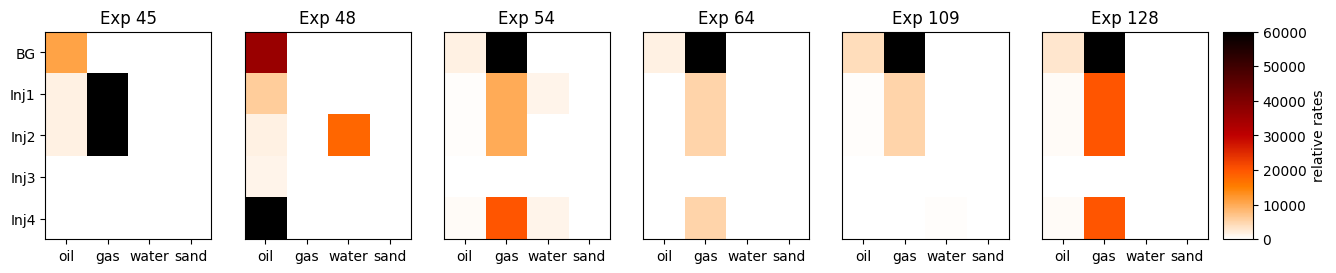

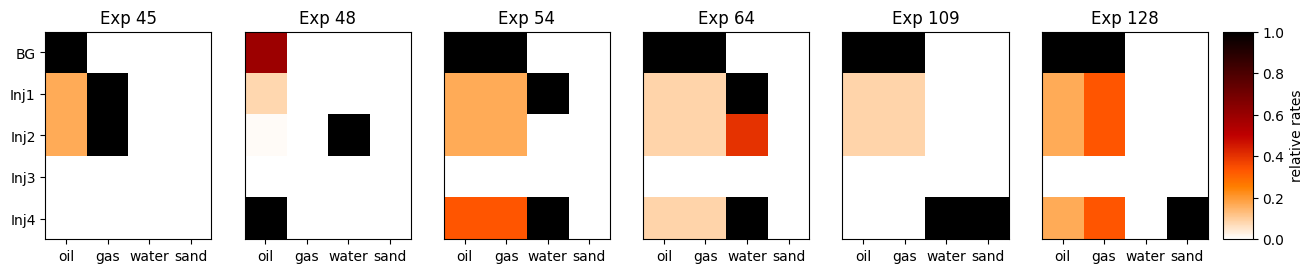

In [6]:
all_flow_orig = np.array([exp45_flow, exp48_flow, exp54_flow, exp64_flow, exp109_flow, exp128_flow])
all_flow_norm = np.array([flow45_norm, flow48_norm, flow54_norm, 
                          flow64_norm, flow109_norm, flow128_norm])

print('Original: {} | Normalized: {}'.format(all_flow_orig.shape, all_flow_norm.shape))
plot_relative_rates(all_flow_orig, cmap='gist_heat_r')
plot_relative_rates(all_flow_norm, cmap='gist_heat_r')

In [131]:
print(all_flow_norm.shape)
print(all_flow_norm.sum(1))
print()
print(my_normalize(all_flow_norm.sum(1))[0])

(6, 5, 4)
[[1.33333333 2.         0.         0.        ]
 [1.68367347 0.         1.         0.        ]
 [1.66666667 1.6666664  2.         0.        ]
 [1.25       1.2499999  2.4        0.        ]
 [1.16666667 1.16666667 1.         1.        ]
 [1.5        2.         0.         1.        ]]

[[0.32236842 1.         0.         0.        ]
 [1.         0.         0.41666667 0.        ]
 [0.96710526 0.8333332  0.83333333 0.        ]
 [0.16118421 0.62499995 1.         0.        ]
 [0.         0.58333333 0.41666667 1.        ]
 [0.64473684 1.         0.         1.        ]]


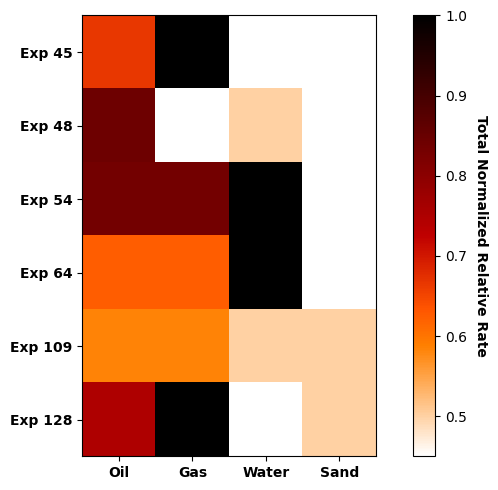

In [157]:
plt.figure(figsize=(10,5))

plt.imshow(all_flow_norm.sum(1)/2, cmap='gist_heat_r', vmin=0.45, vmax=1)
cb = plt.colorbar(pad=0.04, fraction=0.046)
cb.set_label('Total Normalized Relative Rate', rotation=270, labelpad=15, weight='bold')

plt.xticks(range(4), labels=['Oil', 'Gas', 'Water', 'Sand'], weight='bold')
plt.yticks(range(6), labels=['Exp 45', 'Exp 48', 'Exp 54', 'Exp 64', 'Exp 109', 'Exp 128'], weight='bold')

plt.tight_layout()
plt.show()

Individual Flow shapes: (200, 4) (200, 4) (200, 4) (200, 4) (200, 4) (200, 4)


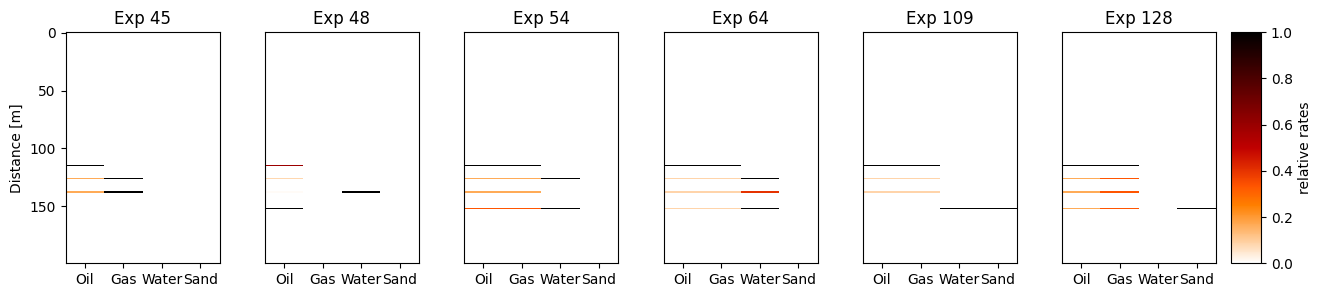

In [7]:
inj_idx = [115, 126, 138, 142, 152]

flow45  = make_sparse_flowrates(all_flow_norm[0], inj_idx)
flow48  = make_sparse_flowrates(all_flow_norm[1], inj_idx)
flow54  = make_sparse_flowrates(all_flow_norm[2], inj_idx)
flow64  = make_sparse_flowrates(all_flow_norm[3], inj_idx)
flow109 = make_sparse_flowrates(all_flow_norm[4], inj_idx)
flow128 = make_sparse_flowrates(all_flow_norm[5], inj_idx)
flow = np.array([flow45, flow48, flow54, flow64, flow109, flow128])

print('Individual Flow shapes:', flow45.shape, flow48.shape,  flow54.shape, 
                                 flow64.shape, flow109.shape, flow128.shape)
plot_relative_mat(flow, cmap='gist_heat_r')

In [8]:
das45,  dts45  = make_daslhs_dts('45')
das48,  dts48  = make_daslhs_dts('48')
das54,  dts54  = make_daslhs_dts('54')
das64,  dts64  = make_daslhs_dts('64')
das109, dts109 = make_daslhs_dts('109')
das128, dts128 = make_daslhs_dts('128')

print('45  - DAS: {} | DTS: {} | Flow: {}'.format(das45.shape, dts45.shape, flow45.shape))
print('128 - DAS: {} | DTS: {} | Flow: {}'.format(das128.shape, dts128.shape, flow128.shape))

45  - DAS: (78, 200, 1) | DTS: (78, 200, 1) | Flow: (200, 4)
128 - DAS: (93, 200, 1) | DTS: (93, 200, 1) | Flow: (200, 4)


In [9]:
print('45  - DAS: {} | DTS: {} | Flow: {}'.format(das45.shape, dts45.shape, flow45.shape))
print('48  - DAS: {} | DTS: {} | Flow: {}'.format(das48.shape, dts48.shape, flow48.shape))
print('54  - DAS: {} | DTS: {} | Flow: {}'.format(das54.shape, dts54.shape, flow54.shape))
print('64  - DAS: {} | DTS: {} | Flow: {}'.format(das64.shape, dts64.shape, flow64.shape))
print('109  - DAS: {} | DTS: {} | Flow: {}'.format(das109.shape, dts109.shape, flow109.shape))
print('128 - DAS: {} | DTS: {} | Flow: {}'.format(das128.shape, dts128.shape, flow128.shape))

45  - DAS: (78, 200, 1) | DTS: (78, 200, 1) | Flow: (200, 4)
48  - DAS: (78, 200, 1) | DTS: (78, 200, 1) | Flow: (200, 4)
54  - DAS: (114, 200, 1) | DTS: (114, 200, 1) | Flow: (200, 4)
64  - DAS: (82, 200, 1) | DTS: (82, 200, 1) | Flow: (200, 4)
109  - DAS: (106, 200, 1) | DTS: (106, 200, 1) | Flow: (200, 4)
128 - DAS: (93, 200, 1) | DTS: (93, 200, 1) | Flow: (200, 4)


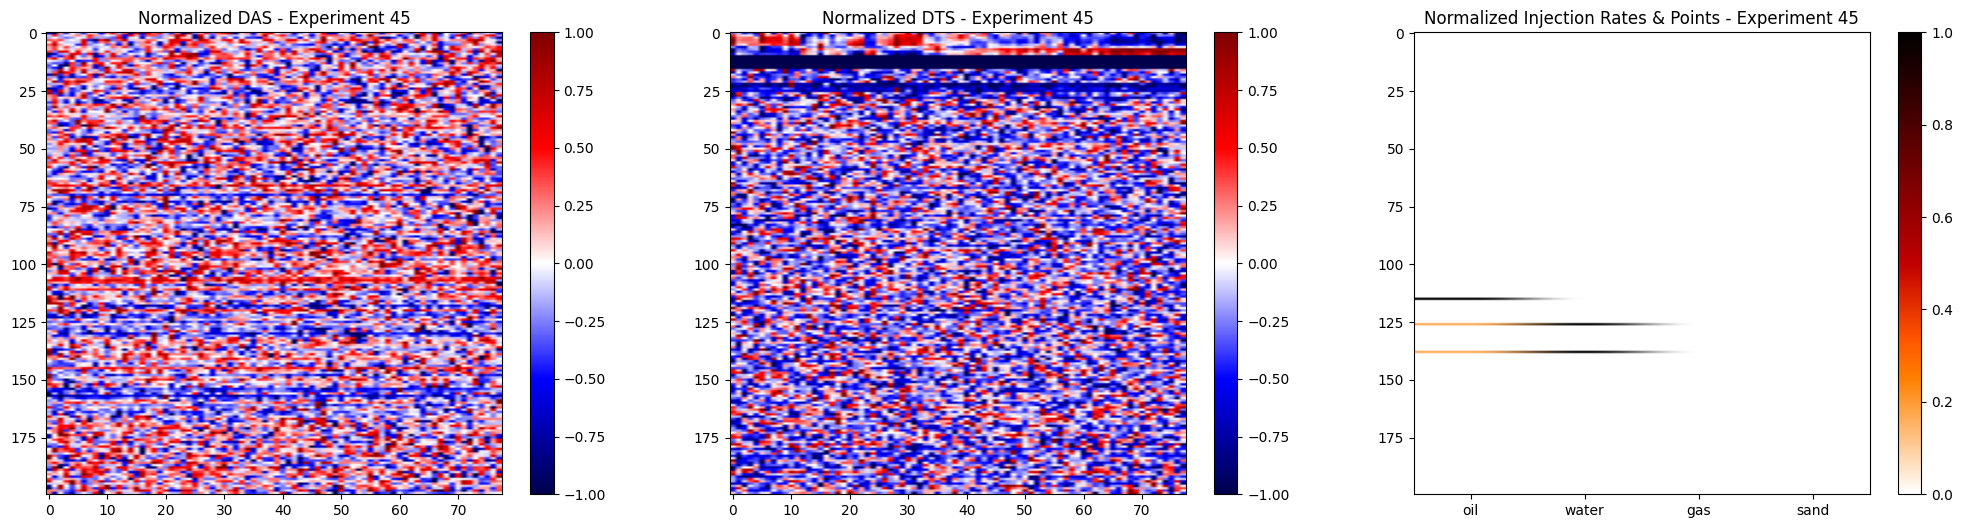

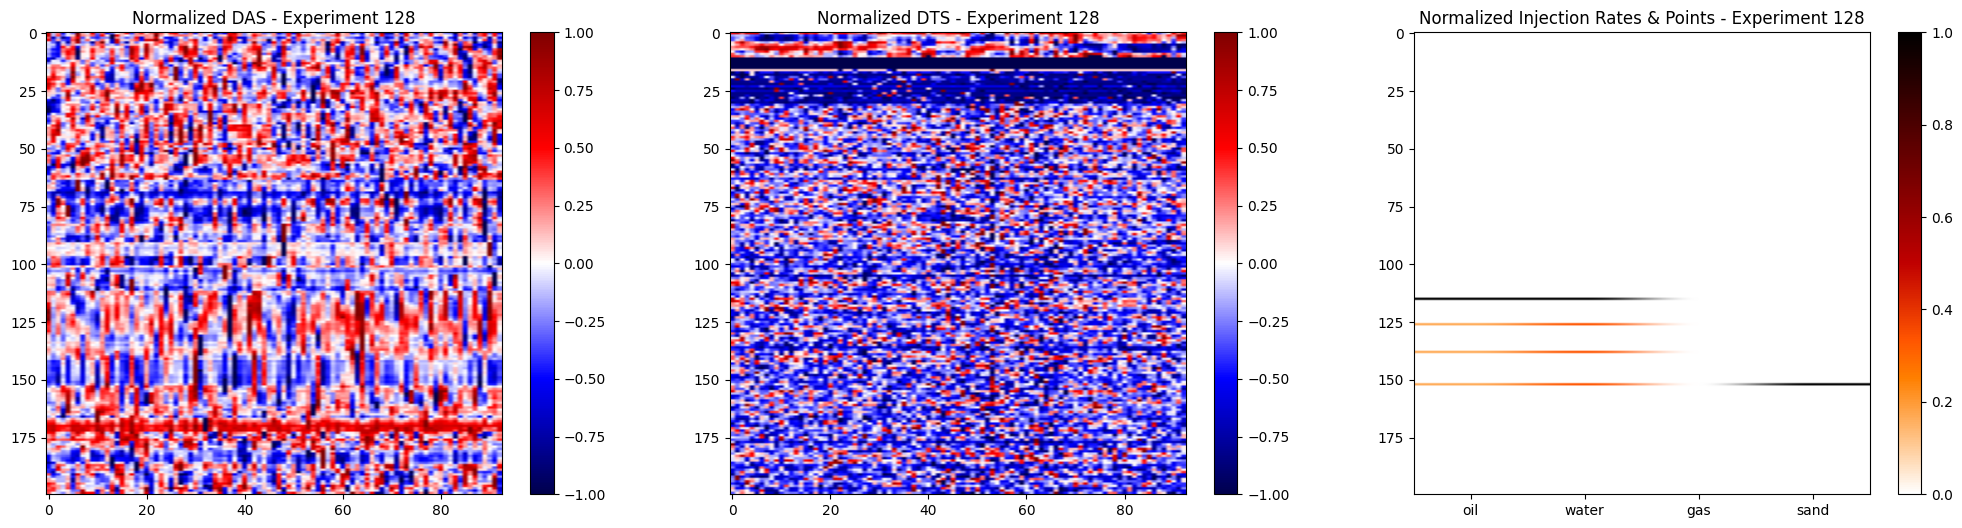

In [10]:
plot_das_dts_flow(das45,  dts45,  flow45,  expnum='45')
plot_das_dts_flow(das128, dts128, flow128, expnum='128')

***

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220


/home/mmorales/miniconda3/envs/flow/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(None, 200, 1))
  warnings.warn(msg)
/home/mmorales/miniconda3/envs/flow/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(32, 200, 1))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
SSIM = 88.66
MSE  = 5.647e-03
PSNR = 28.50


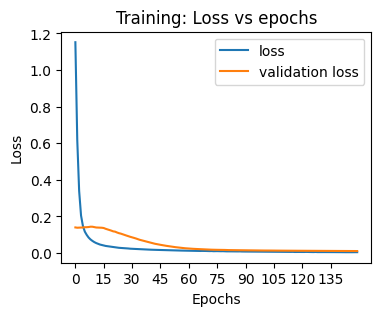

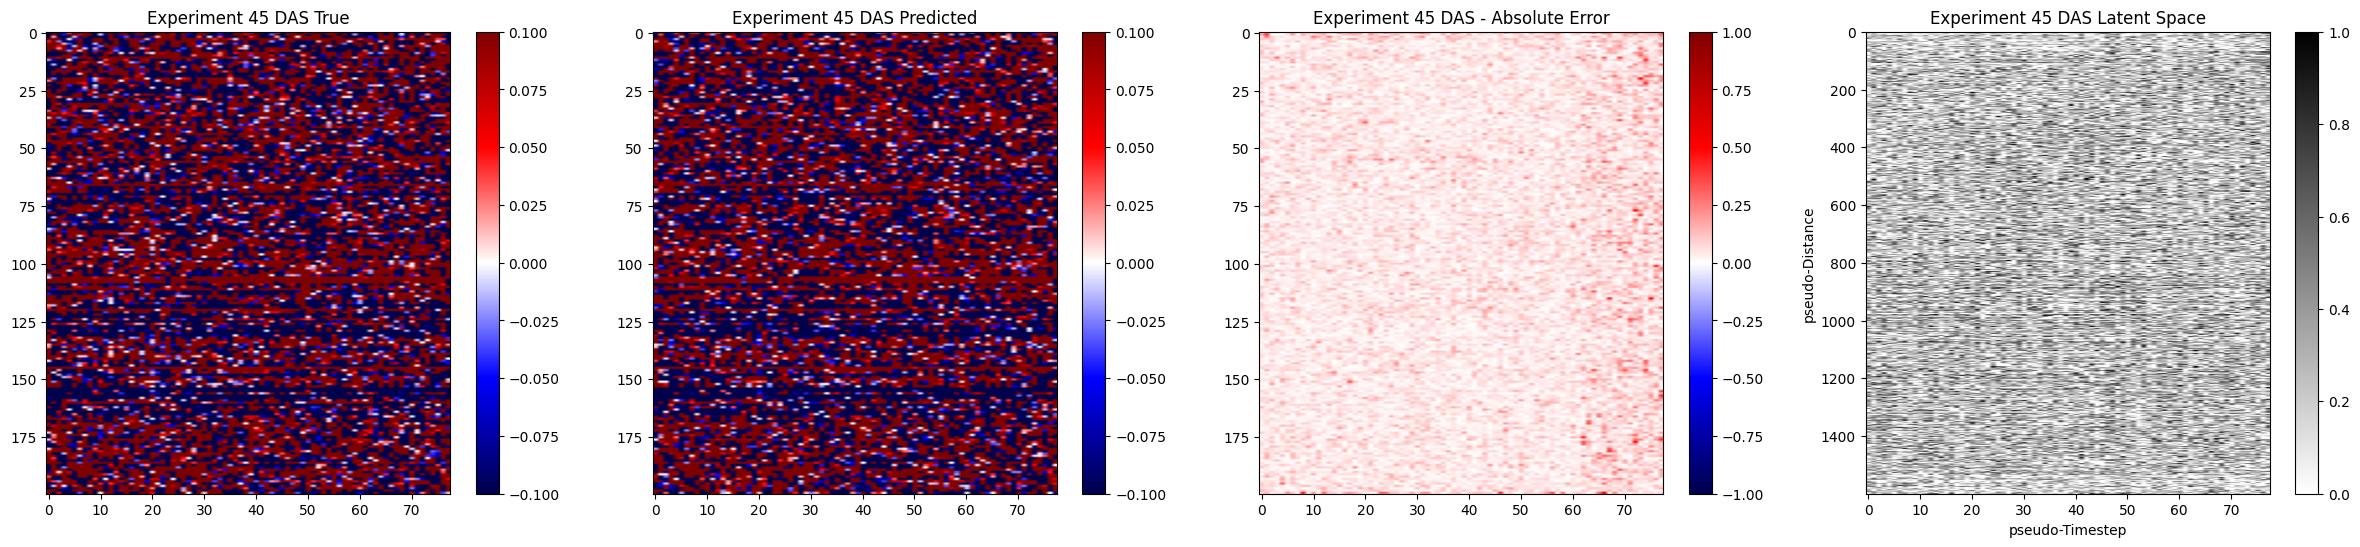

In [200]:
das_m2m, das_m2z = das_Unet()
print('AutoEncoder # of parameters: {:,}'.format(das_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(das_m2z.count_params()))

das_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_das = das_m2m.fit(das45, das45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_das, figsize=(4,3))

das45_pred = das_m2m.predict(das45).squeeze().astype('float64')
das45_z = das_m2z.predict(das45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(das45.squeeze().T, das45_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(das45.squeeze().T, das45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(das45.squeeze().T, das45_pred.T, data_range=2)))

plot_true_pred_z(das45, das45_pred, das45_z, filenum='45 DAS')

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
SSIM = 93.87
MSE  = 1.078e-02
PSNR = 25.70


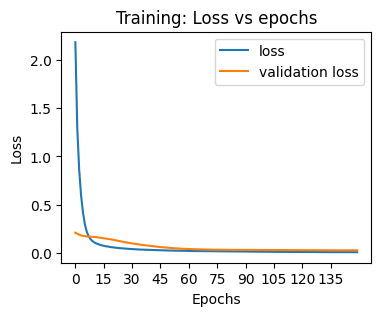

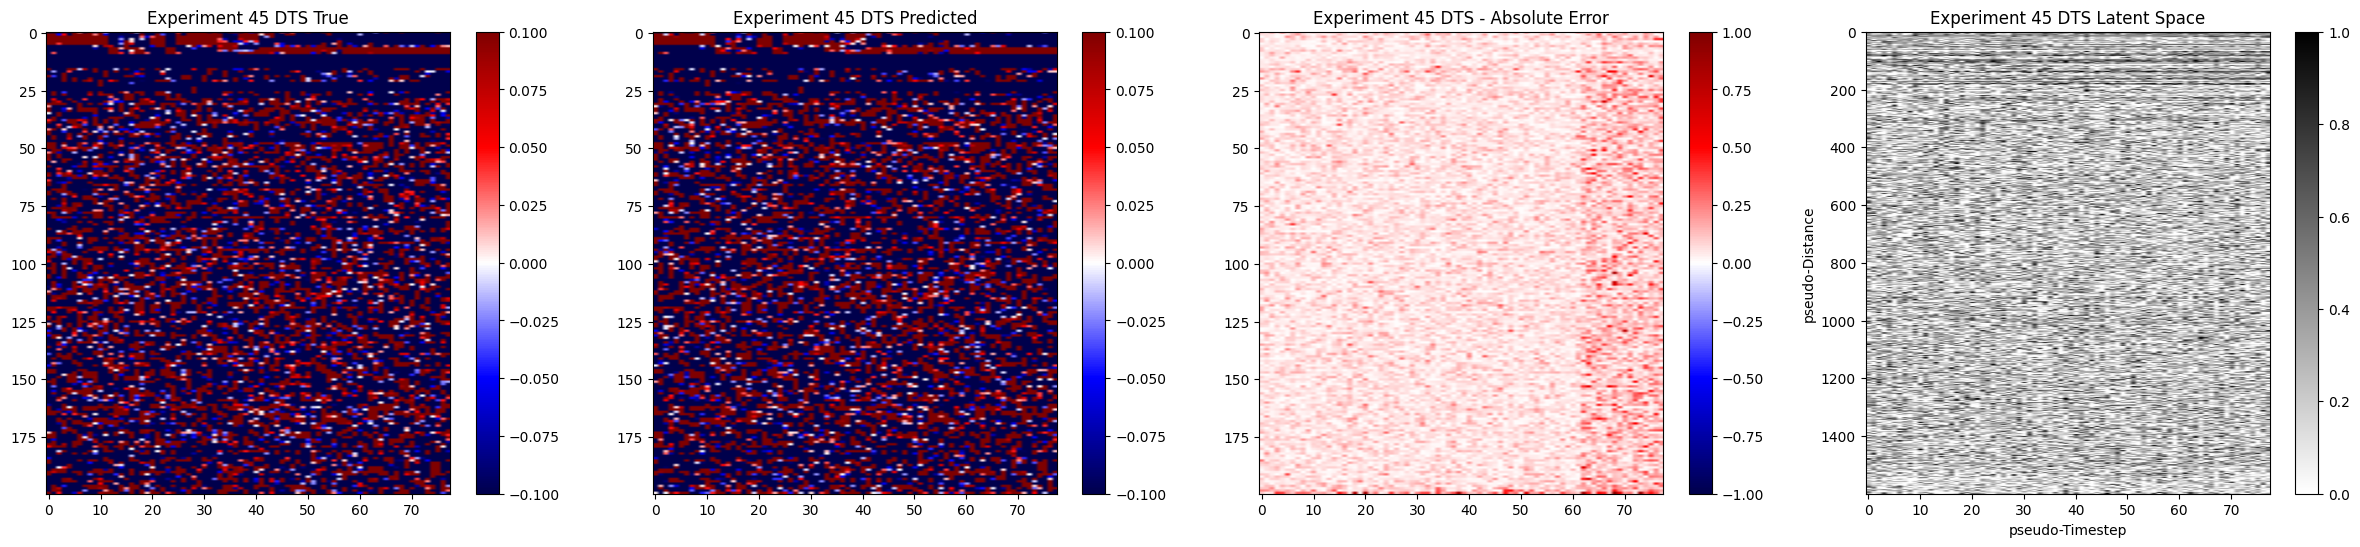

In [201]:
dts_m2m, dts_m2z = dts_Unet()
print('AutoEncoder # of parameters: {:,}'.format(dts_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(dts_m2z.count_params()))

dts_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_dts = dts_m2m.fit(dts45, dts45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_dts, figsize=(4,3))

dts45_pred = dts_m2m.predict(dts45).squeeze().astype('float64')
dts45_z = dts_m2z.predict(dts45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(dts45.squeeze().T, dts45_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(dts45.squeeze().T, dts45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(dts45.squeeze().T, dts45_pred.T, data_range=2)))

plot_true_pred_z(dts45, dts45_pred, dts45_z, filenum='45 DTS')

***

(78, 200) (78, 200)
(78, 200) (78, 200)


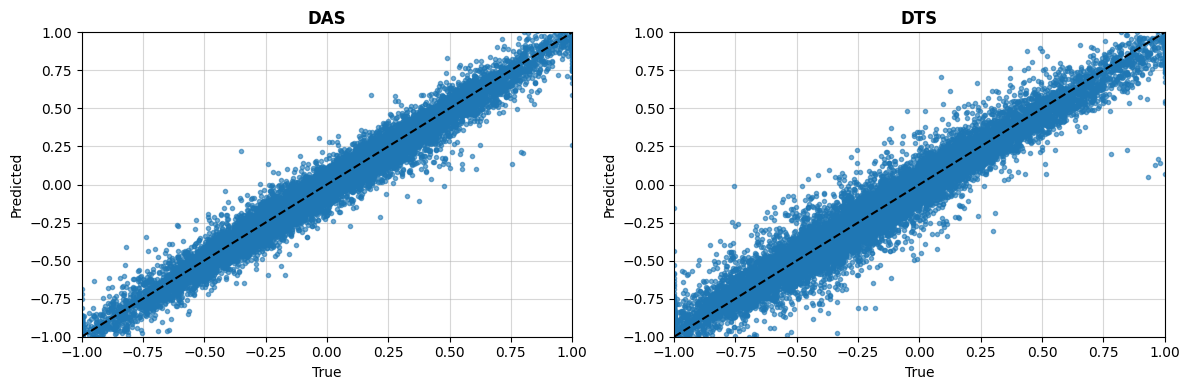

In [ ]:
true_das = das45.squeeze()
pred_das = das45_pred
print(true_das.shape, pred_das.shape)

true_dts = dts45.squeeze()
pred_dts = dts45_pred
print(true_dts.shape, pred_dts.shape)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax1, ax2 = axs

ax1.plot(true_das.flatten(), pred_das.flatten(), 'o', markersize=3, alpha=0.6)
ax2.plot(true_dts.flatten(), pred_dts.flatten(), 'o', markersize=3, alpha=0.6)

[a.axline([0,0],[1,1], c='k', ls='--') for a in axs]
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set(xlim=(-1,1), ylim=(-1,1)) for a in axs]
[a.set(xlabel='True', ylabel='Predicted') for a in axs]
[a.set_title(['DAS','DTS'][i], weight='bold') for i,a in enumerate(axs)]

plt.tight_layout()
plt.show()

In [520]:
def tempo(zdas, zdts, flow, xsteps=200, method=Ridge(alpha=0.1)):
    z_dual = np.concatenate([zdas, zdts]).flatten().reshape(xsteps,-1)
    reg = method
    reg.fit(z_dual, flow)
    flow_pred_f = reg.predict(z_dual)
    mse = mean_squared_error(flow, flow_pred_f)
    return [reg.alpha, mse]

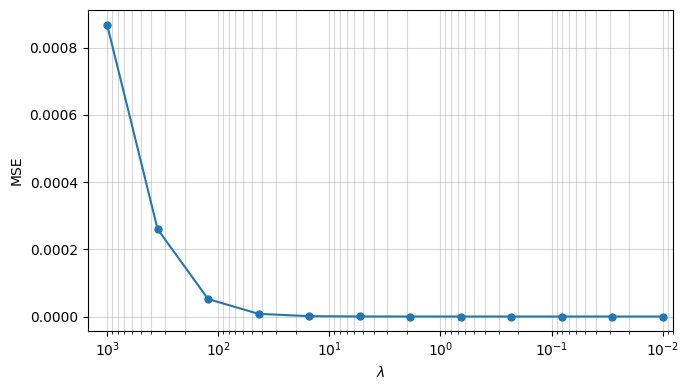

In [521]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
alphas = np.logspace(-2, 3, 12)
aa_ridge, ee_ridge = [], []
aa_lasso, ee_lasso = [], []

for a in alphas:
    [a2, m2] = tempo(das45_z, dts45_z, flow45, method=Ridge(a))
    aa_ridge.append(a2)
    ee_ridge.append(m2)

plt.figure(figsize=(7,4))
plt.plot(aa_ridge, ee_ridge, 'o-', markersize=5, label='Ridge')
plt.xscale('log')
plt.xlim(1.5e3, 8e-3)
plt.xlabel('$\lambda$', weight='bold')
plt.ylabel('MSE')
plt.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

MSE:  4.84e-09
SSIM: 1.000


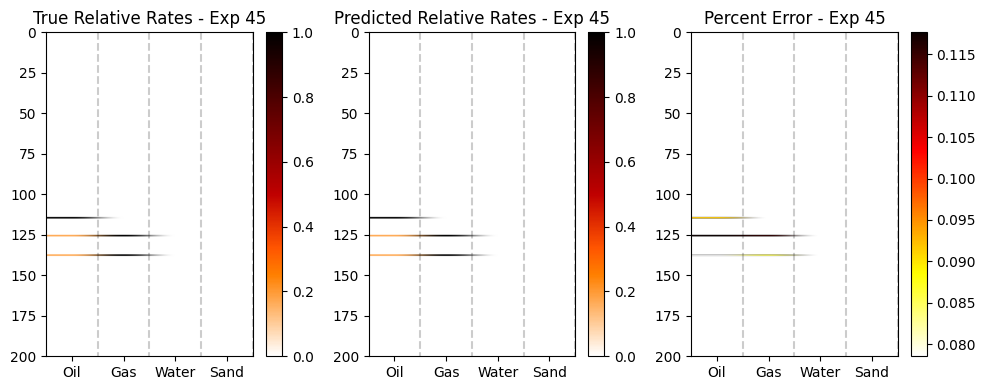

In [438]:
reg = make_flowpred_from_dual_latent(das45_z, dts45_z, flow45, expnum='45', method=Ridge())

Shapes - z_DAS: (93, 25, 64) | z_DTS: (93, 25, 64)
MSE:  5.59e-09
SSIM: 1.000


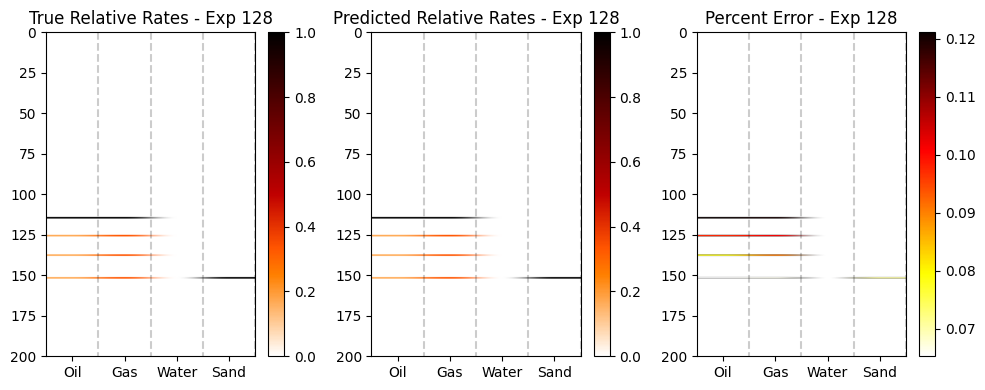

In [15]:
# Transfer Learning
transfer_learning_predictions_dual(das128, dts128, flow128, das_m2z, dts_m2z, expnum='128', method=Ridge())

***
## Make Dictionaries from data and models

In [16]:
flow_dict = {'45':flow45, '48':flow48, '54':flow54, '64':flow64, '109':flow109, '128':flow128}

In [17]:
models = {'das': {'m2m':das_m2m, 'm2z':das_m2z},
          'dts': {'m2m':dts_m2m, 'm2z':dts_m2z}}

In [18]:
all_data = {'das': {'45':das45, '48':das48, '54':das54, '64':das64, '109':das109, '128':das128}, 
            'dts': {'45':dts45, '48':dts48, '54':dts54, '64':dts64, '109':dts109, '128':dts128}}

In [408]:
das_m2z.predict(das45).shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


(78, 25, 64)

In [413]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

tsne_das45 = tsne.fit_transform(das_m2z.predict(das45, verbose=False).reshape(-1,64))
tsne_das48 = tsne.fit_transform(das_m2z.predict(das48, verbose=False).reshape(-1,64))
tsne_das54 = tsne.fit_transform(das_m2z.predict(das54, verbose=False).reshape(-1,64))
tsne_das64 = tsne.fit_transform(das_m2z.predict(das64, verbose=False).reshape(-1,64))
tsne_das109 = tsne.fit_transform(das_m2z.predict(das109, verbose=False).reshape(-1,64))
tsne_das128 = tsne.fit_transform(das_m2z.predict(das128, verbose=False).reshape(-1,64))

tsne_dts45 = tsne.fit_transform(dts_m2z.predict(dts45, verbose=False).reshape(-1,64))
tsne_dts48 = tsne.fit_transform(dts_m2z.predict(dts48, verbose=False).reshape(-1,64))
tsne_dts54 = tsne.fit_transform(dts_m2z.predict(dts54, verbose=False).reshape(-1,64))
tsne_dts64 = tsne.fit_transform(dts_m2z.predict(dts64, verbose=False).reshape(-1,64))
tsne_dts109 = tsne.fit_transform(dts_m2z.predict(dts109, verbose=False).reshape(-1,64))
tsne_dts128 = tsne.fit_transform(dts_m2z.predict(dts128, verbose=False).reshape(-1,64))

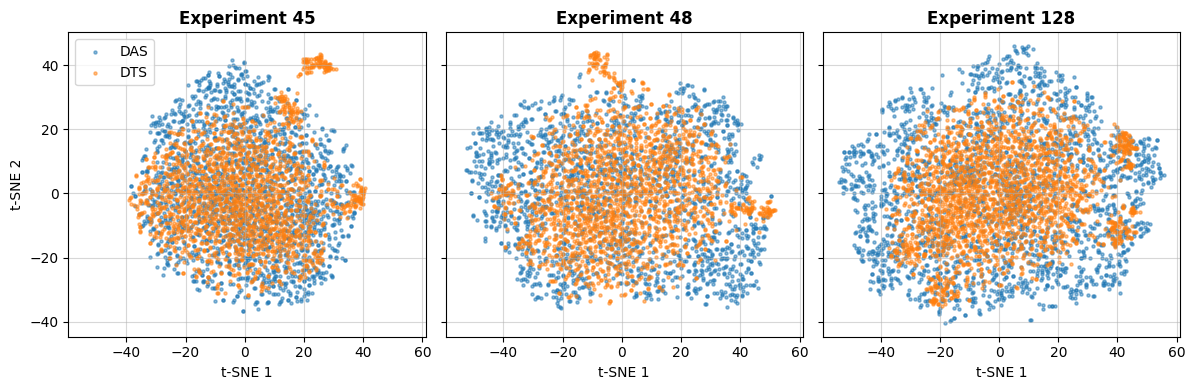

In [437]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax1, ax2, ax3 = axs

ax1.scatter(tsne_das45[:,0], tsne_das45[:,1], c='C0', s=5, alpha=0.5, label='DAS')
ax1.scatter(tsne_dts45[:,0], tsne_dts45[:,1], c='C1', s=5, alpha=0.5, label='DTS')

ax2.scatter(tsne_das48[:,0], tsne_das48[:,1], c='C0', s=5, alpha=0.5, label='DAS')
ax2.scatter(tsne_dts48[:,0], tsne_dts48[:,1], c='C1', s=5, alpha=0.5, label='DTS')

ax3.scatter(tsne_das128[:,0], tsne_das128[:,1], c='C0', s=5, alpha=0.5, label='DAS')
ax3.scatter(tsne_dts128[:,0], tsne_dts128[:,1], c='C1', s=5, alpha=0.5, label='DTS')

ax1.legend(loc='upper left')
[a.grid(True, which='both', alpha=0.5) for a in axs]
[a.set_title('Experiment {}'.format(['45','48','128'][i]), weight='bold') for i,a in enumerate(axs)]
[a.set(xlabel='t-SNE 1') for a in axs]
ax1.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

***
## Single Latent Space

In [19]:
single_latents = make_single_latents(models, all_data)

DAS Latent Spaces: 
---------------------------------------------------------
45: (78, 25, 64) | 48: (78, 25, 64)   | 54: (114, 25, 64)
64: (82, 25, 64) | 109: (106, 25, 64) | 128: (93, 25, 64)
---------------------------------------------------------

DTS Latent Spaces: 
---------------------------------------------------------
45: (78, 25, 64) | 48: (78, 25, 64)   | 54: (114, 25, 64)
64: (82, 25, 64) | 109: (106, 25, 64) | 128: (93, 25, 64)
---------------------------------------------------------


In [265]:
def flowpred(zdas, zdts, flow, xsteps=200, method=LinearRegression()):
    z_dual = np.concatenate([zdas, zdts]).flatten().reshape(xsteps,-1)
    reg = method
    reg.fit(z_dual, flow)
    flow_pred_f = reg.predict(z_dual)
    flow_pred   = np.reshape(flow_pred_f, flow.shape)
    return flow_pred

In [278]:
pred45 = flowpred(single_latents['das']['45'], single_latents['dts']['45'], flow_dict['45'])
pred48 = flowpred(single_latents['das']['48'], single_latents['dts']['48'], flow_dict['48'])
pred54 = flowpred(single_latents['das']['54'], single_latents['dts']['54'], flow_dict['54'])
pred64 = flowpred(single_latents['das']['64'], single_latents['dts']['64'], flow_dict['64'])
pred109 = flowpred(single_latents['das']['109'], single_latents['dts']['109'], flow_dict['109'])
pred128 = flowpred(single_latents['das']['128'], single_latents['dts']['128'], flow_dict['128'])
all_preds = np.array([pred45, pred48, pred54, pred64, pred109, pred128])
print(all_preds.shape)

(6, 200, 4)


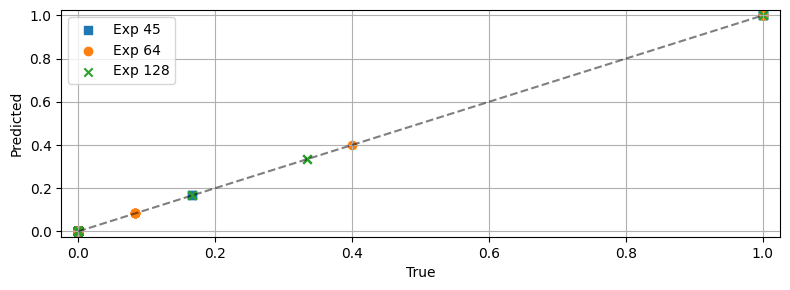

In [398]:
plt.figure(figsize=(8,3))
plt.grid(True, which='both')
plt.scatter(flow45, pred45, label='Exp 45', c='C0', marker='s')
plt.scatter(flow64, pred64, label='Exp 64', c='C1', marker='o')
plt.scatter(flow128, pred128, label='Exp 128', c='C2', marker='x')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.xlim(-0.025,1.025)
plt.ylim(-0.025,1.025)
plt.tight_layout()
plt.show()

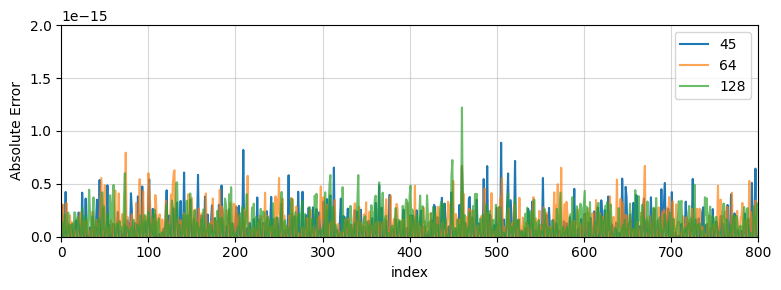

In [388]:
plt.figure(figsize=(8,3))

def calc_error(true, pred):
    return np.abs(true.flatten() - pred.flatten())

plt.plot(calc_error(flow45, pred45), label='45')
plt.plot(calc_error(flow64, pred64), alpha=0.7, label='64')
plt.plot(calc_error(flow128, pred128), alpha=0.7, label='128')
plt.legend(loc='upper right')
plt.xlim(0,800)
plt.ylim(0, 2e-15)
plt.grid(True, which='both', alpha=0.5)

plt.xlabel('index')
plt.ylabel('Absolute Error')

plt.tight_layout()
plt.show()

DAS only: MSE=6.56e-08, SSIM=1.000
DTS only: MSE=5.78e-08, SSIM=1.000
Dual:     MSE=5.32e-09, SSIM=1.000


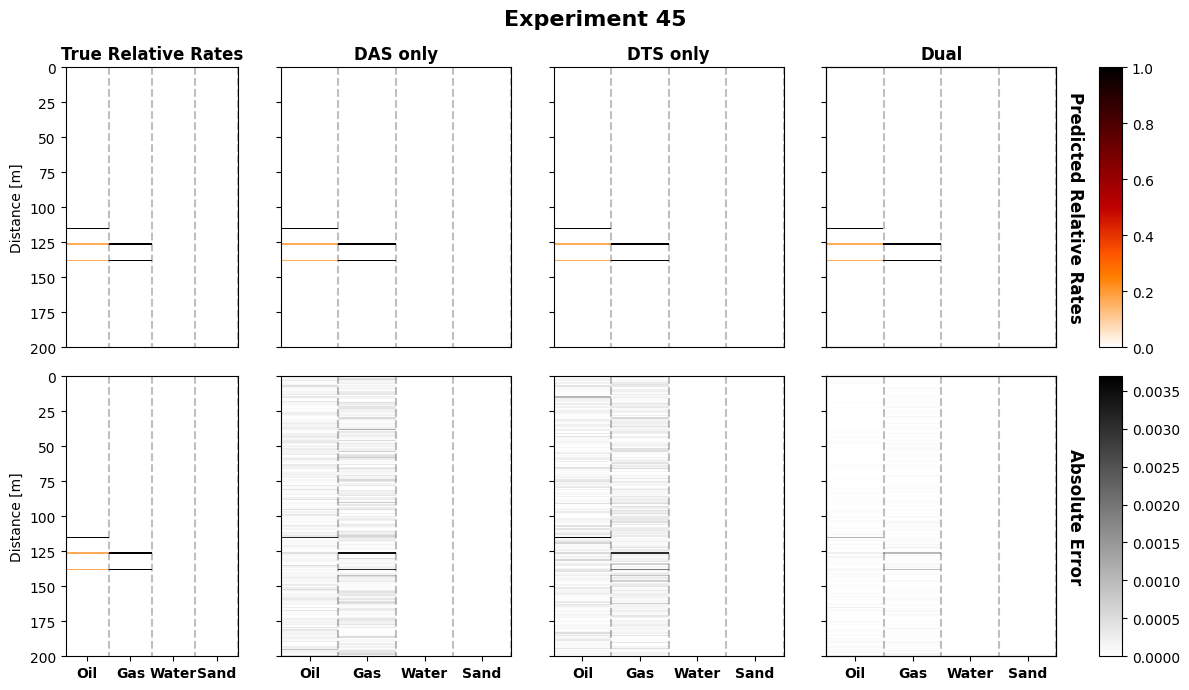

DAS only: MSE=7.94e-08, SSIM=1.000
DTS only: MSE=6.12e-08, SSIM=1.000
Dual:     MSE=6.11e-09, SSIM=1.000
DAS only: MSE=2.12e-08, SSIM=1.000
DTS only: MSE=2.65e-08, SSIM=1.000
Dual:     MSE=3.89e-09, SSIM=1.000
DAS only: MSE=5.82e-08, SSIM=1.000
DTS only: MSE=5.22e-08, SSIM=1.000
Dual:     MSE=7.02e-09, SSIM=1.000
DAS only: MSE=4.28e-08, SSIM=1.000
DTS only: MSE=4.53e-08, SSIM=1.000
Dual:     MSE=2.71e-09, SSIM=1.000
DAS only: MSE=3.34e-08, SSIM=1.000
DTS only: MSE=1.77e-08, SSIM=1.000
Dual:     MSE=5.59e-09, SSIM=1.000


In [306]:
pred45_dict = make_flowpred_from_single_latent(single_latents, flow_dict, expnum='45', method=Ridge(), plot=True)
pred48_dict = make_flowpred_from_single_latent(single_latents, flow_dict, expnum='48', method=Ridge(), plot=False)
pred54_dict = make_flowpred_from_single_latent(single_latents, flow_dict, expnum='54', method=Ridge(), plot=False)
pred64_dict = make_flowpred_from_single_latent(single_latents, flow_dict, expnum='64', method=Ridge(), plot=False)
pred109_dict = make_flowpred_from_single_latent(single_latents, flow_dict, expnum='109', method=Ridge(), plot=False)
pred128_dict = make_flowpred_from_single_latent(single_latents, flow_dict, expnum='128', method=Ridge(), plot=False)

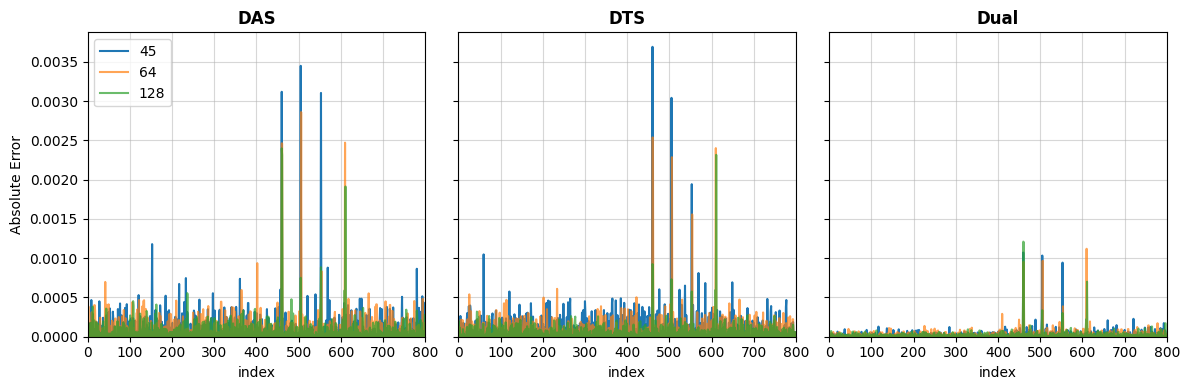

In [370]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax1, ax2, ax3 = axs

def calc_error(true, pred):
    return np.abs(true.flatten() - pred.flatten())

ax1.plot(calc_error(flow45, pred45_dict['das']), label='45')
ax1.plot(calc_error(flow64, pred64_dict['das']), alpha=0.7, label='64')
ax1.plot(calc_error(flow128, pred128_dict['das']), alpha=0.7, label='128')
ax1.legend(loc='upper left')

ax2.plot(calc_error(flow45, pred45_dict['dts']), label='45')
ax2.plot(calc_error(flow64, pred64_dict['dts']), alpha=0.7, label='64')
ax2.plot(calc_error(flow128, pred128_dict['dts']), alpha=0.7, label='128')

ax3.plot(calc_error(flow45, pred45_dict['dual']))
ax3.plot(calc_error(flow64, pred64_dict['dual']), alpha=0.7)
ax3.plot(calc_error(flow128, pred128_dict['dual']), alpha=0.7)

ax1.set(xlim=(0,800), ylim=(0,None))
[a.set(xlabel='index') for a in axs]
ax1.set_ylabel('Absolute Error')
[a.set_title(['DAS','DTS','Dual'][i], weight='bold') for i,a in enumerate(axs)]
[a.grid(True, which='both', alpha=0.5) for a in axs]

plt.tight_layout()
plt.show()

***
## Uncertainty Quantification

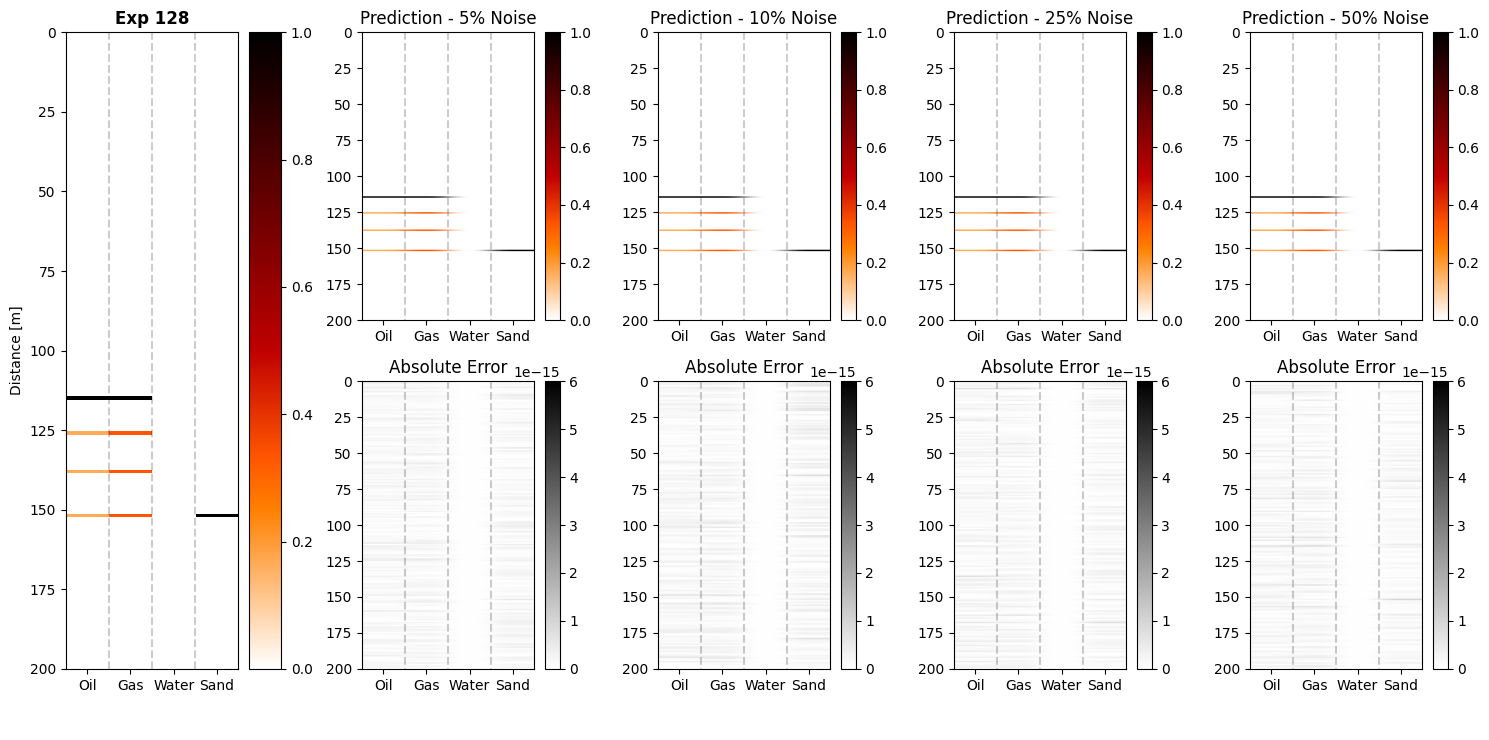

In [21]:
make_uq_pred_dual('128', all_data, models, flow_dict)

***
# END